In [431]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances


In [432]:
data_path = "dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:07<00:00, 18.02it/s]


In [433]:
# let's see one of the conversations
pprint(code2convos["0c95c563-f1e1-4a35-844c-2e8ccdd1b161"][0])

{'role': 'user',
 'text': 'Hello! I want to make your help on my homework about machine '
         'learning with Python usage. We will go section by section firstly i '
         'want to read a csv file with the pandas library in the given path '
         '/content/cs412_hw1_dataset.csv '}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [434]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts    

In [435]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [436]:
questions = [
"""
First make a copy of the notebook given to you as a starter.
Make sure you choose Connect form upper right.
You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.
""",
"""
Load training dataset (5 pts)
Read the .csv file with the pandas library
""",
"""
Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
Display variable names (both dependent and independent).
Display the summary of the dataset. (Hint: You can use the **info** function)
Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**
Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""
Set X & y, split data (5 pts)
Shuffle the dataset.
Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
Split training and test sets as 80% and 20%, respectively.
""",
"""
Features and Correlations (10 pts)
Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.
Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.
Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.
""",
"""
Tune Hyperparameters (20 pts)
Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
"""
Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
"""
Test your classifier on the test set (20 pts)
Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
Report the classification accuracy. (2 pts)
Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
"""
Find the information gain on the first split (10 pts)
""",
]

In [437]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [438]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [439]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [440]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [441]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

In [442]:
code2sim = dict()

# Calculate both cosine and Jaccard similarities
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    cosine_similarity_scores = cosine_similarity(questions_TF_IDF, user_prompts_tf_idf)
    jaccard_similarity_scores = 1 - pairwise_distances(questions_TF_IDF, user_prompts_tf_idf, metric='hamming')
    
    # Combine
    combined_similarity = 0.7 * cosine_similarity_scores + 0.3 * jaccard_similarity_scores
    
    code2sim[code] = pd.DataFrame(combined_similarity)

In [443]:
questions[4]

"\nFeatures and Correlations (10 pts)\nCorrelations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\nFeature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\nHypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n"

In [444]:
code2questionmapping = dict()
for code, cosine_scores in code2sim.items():
    code2questionmapping[code] = code2sim[code].max(axis=1).tolist()

question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.404696,0.504360,0.661393,0.543236,0.630747,0.684149,0.413625,0.422565,0.435141
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.433695,0.856314,0.836484,0.916248,0.747663,0.988869,0.923310,0.696847,0.679706
2,041f950b-c013-409a-a642-cffff60b9d4b,0.466550,0.491695,0.721944,0.530858,0.767416,0.602586,0.662764,0.667065,0.512603
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.400658,0.381487,0.483319,0.519877,0.540651,0.512966,0.432992,0.480549,0.583918
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.541251,0.701701,0.844195,0.736050,0.835107,0.908127,0.777529,0.959104,0.657013
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.429752,0.445026,0.546856,0.444259,0.400830,0.647106,1.000000,0.901089,0.816574
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.398444,0.394589,0.527382,0.963908,0.869990,0.877132,0.558697,0.931094,0.686443
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.440400,0.935366,0.980631,0.945462,0.956584,0.942306,0.843591,0.834300,0.648489
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.417448,0.976514,1.000000,0.790180,1.000000,0.932805,1.000000,1.000000,0.847112


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [445]:
import re
from collections import defaultdict

code2features = defaultdict(lambda: defaultdict(int))

keywords_to_search = ['pts', 'points']
keywords_to_search = [kw.lower() for kw in keywords_to_search]
question_words = ['?', 'who', 'what', 'when', 'where', 'why', 'how']
uncertainty_words = ['possible', 'might', 'could', 'may']
directive_words = ['next', 'section', 'step', 'wait', 'provided', 'modify']

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # Count the user prompts
            code2features[code]["#user_prompts"] += 1

            # Count the keywords
            for kw in keywords_to_search:
                code2features[code][f"#{kw}"] += len(re.findall(rf"{kw}", text))

            # Determine if the user prompt is a question or a statement
            if any(q_word in text for q_word in question_words):
                code2features[code]["question_or_statement"] += 1  # Consider it as a question
            else:
                code2features[code]["question_or_statement"] -= 1  # Consider it as a statement

            # Consider it as a directive answer
            if any(d_word in text for d_word in directive_words):
                code2features[code]["directive_words"] += 1

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

            # Consider it as a uncertain answer
            if any(u_word in text for u_word in uncertainty_words):
                code2features[code]["uncertainty_in_answers"] += 1

    code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
    code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]


139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [446]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#pts,#points,question_or_statement,prompt_avg_chars,response_avg_chars,uncertainty_in_answers,directive_words
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,4.0,407.214286,2218.500000,4.0,2.0
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,7.0,0.0,-4.0,261.111111,1653.111111,5.0,NaN
041f950b-c013-409a-a642-cffff60b9d4b,9.0,10.0,1.0,-5.0,663.000000,1636.222222,2.0,1.0
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,-4.0,114.100000,1749.900000,1.0,NaN
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,7.0,3.0,-6.0,217.081395,1455.441860,22.0,2.0


In [447]:
# reading the scores
scores = pd.read_csv("scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


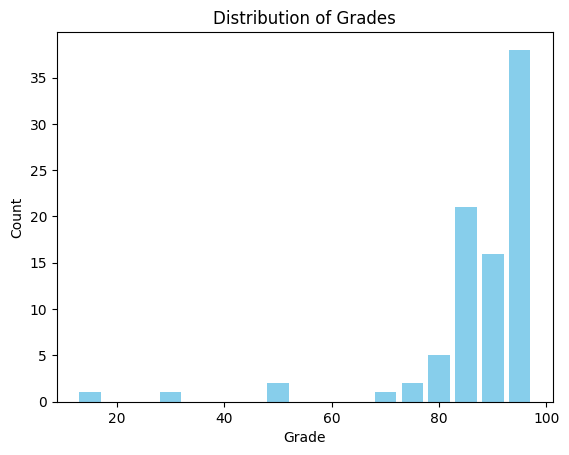

In [457]:
# Check grades distribution
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+5, 5) - 2.5, color='skyblue')
plt.title('Distribution of Grades')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

In [449]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#pts,#points,question_or_statement,prompt_avg_chars,response_avg_chars,uncertainty_in_answers,directive_words
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,4.0,407.214286,2218.500000,4.0,2.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,7.0,0.0,-4.0,261.111111,1653.111111,5.0,NaN
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,10.0,1.0,-5.0,663.000000,1636.222222,2.0,1.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,-4.0,114.100000,1749.900000,1.0,NaN
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,7.0,3.0,-6.0,217.081395,1455.441860,22.0,2.0


In [450]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#pts,#points,question_or_statement,prompt_avg_chars,response_avg_chars,uncertainty_in_answers,directive_words,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,4.0,407.214286,2218.500000,4.0,2.0,0.404696,0.504360,0.661393,0.543236,0.630747,0.684149,0.413625,0.422565,0.435141
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,7.0,0.0,-4.0,261.111111,1653.111111,5.0,NaN,0.433695,0.856314,0.836484,0.916248,0.747663,0.988869,0.923310,0.696847,0.679706
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,10.0,1.0,-5.0,663.000000,1636.222222,2.0,1.0,0.466550,0.491695,0.721944,0.530858,0.767416,0.602586,0.662764,0.667065,0.512603
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,0.0,0.0,-4.0,114.100000,1749.900000,1.0,NaN,0.400658,0.381487,0.483319,0.519877,0.540651,0.512966,0.432992,0.480549,0.583918
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,7.0,3.0,-6.0,217.081395,1455.441860,22.0,2.0,0.541251,0.701701,0.844195,0.736050,0.835107,0.908127,0.777529,0.959104,0.657013


#### Merging scores with features

In [451]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#pts,#points,question_or_statement,prompt_avg_chars,response_avg_chars,uncertainty_in_answers,directive_words,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,0.0,0.0,4.0,407.214286,2218.500000,4.0,2.0,0.404696,0.504360,0.661393,0.543236,0.630747,0.684149,0.413625,0.422565,0.435141,48.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,10.0,1.0,-5.0,663.000000,1636.222222,2.0,1.0,0.466550,0.491695,0.721944,0.530858,0.767416,0.602586,0.662764,0.667065,0.512603,90.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,7.0,3.0,-6.0,217.081395,1455.441860,22.0,2.0,0.541251,0.701701,0.844195,0.736050,0.835107,0.908127,0.777529,0.959104,0.657013,100.0
5,090d6217-5d69-4929-a342-19abab78324f,73.0,9.0,1.0,-49.0,300.191781,1476.150685,20.0,2.0,0.426471,0.800652,0.754261,0.795712,0.800893,0.908127,0.854789,0.754102,0.866616,84.0
7,0c95c563-f1e1-4a35-844c-2e8ccdd1b161,15.0,3.0,0.0,-5.0,340.466667,1837.400000,8.0,6.0,0.520571,0.586899,0.681050,0.821845,0.852098,0.878897,0.856925,0.862225,0.626187,96.0


In [452]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(75, 17) (75,)


#### K-fold Cross Validation

Turn:  0
Train set size: 60
Test set size: 15


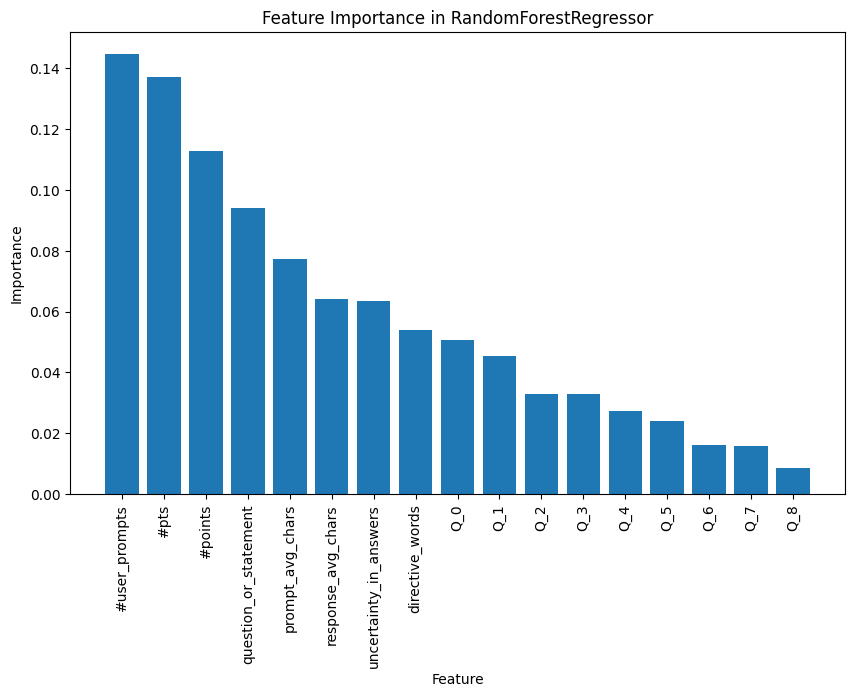

----------
Turn:  1
Train set size: 60
Test set size: 15


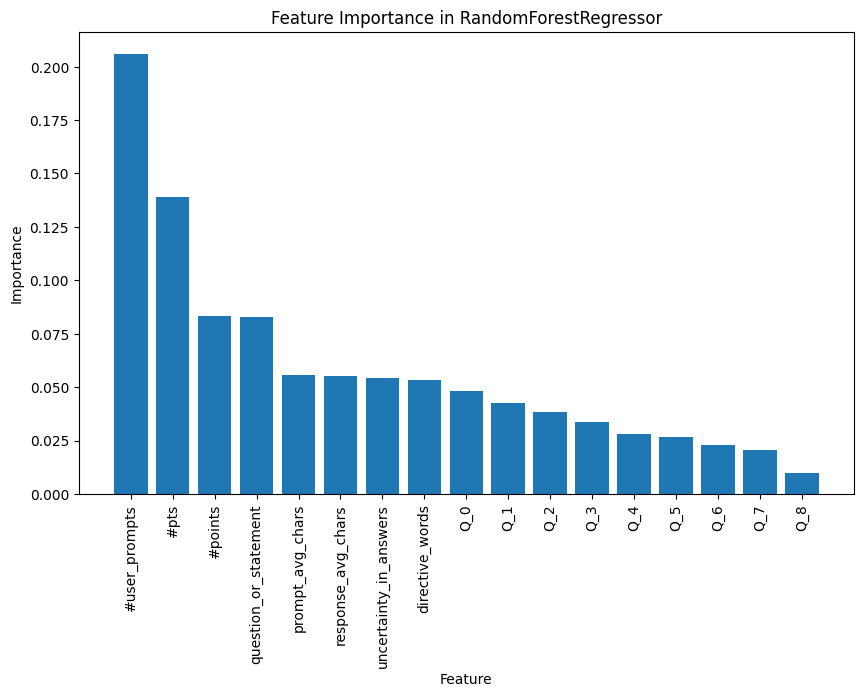

----------
Turn:  2
Train set size: 60
Test set size: 15


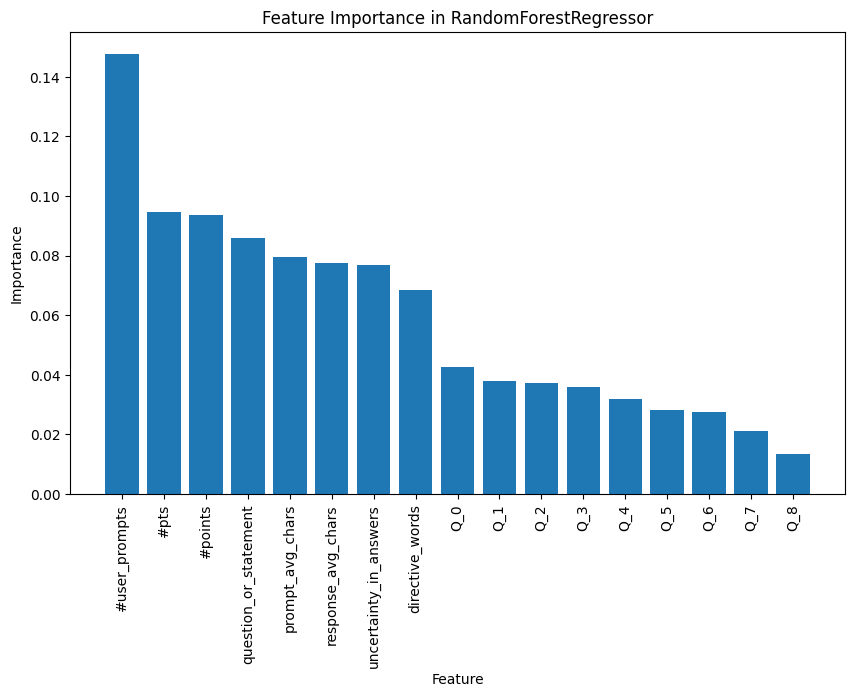

----------
Turn:  3
Train set size: 60
Test set size: 15


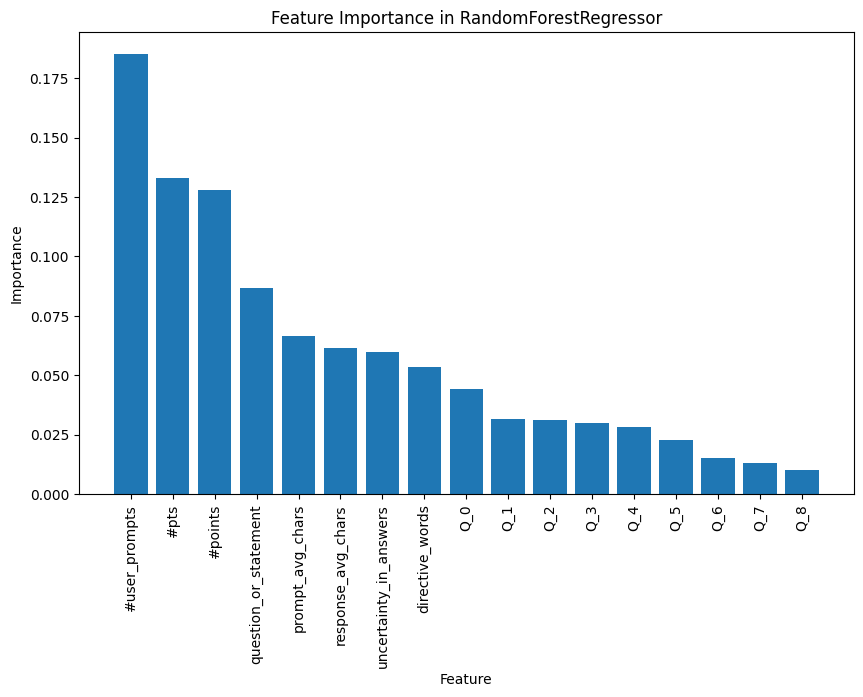

----------
Turn:  4
Train set size: 60
Test set size: 15


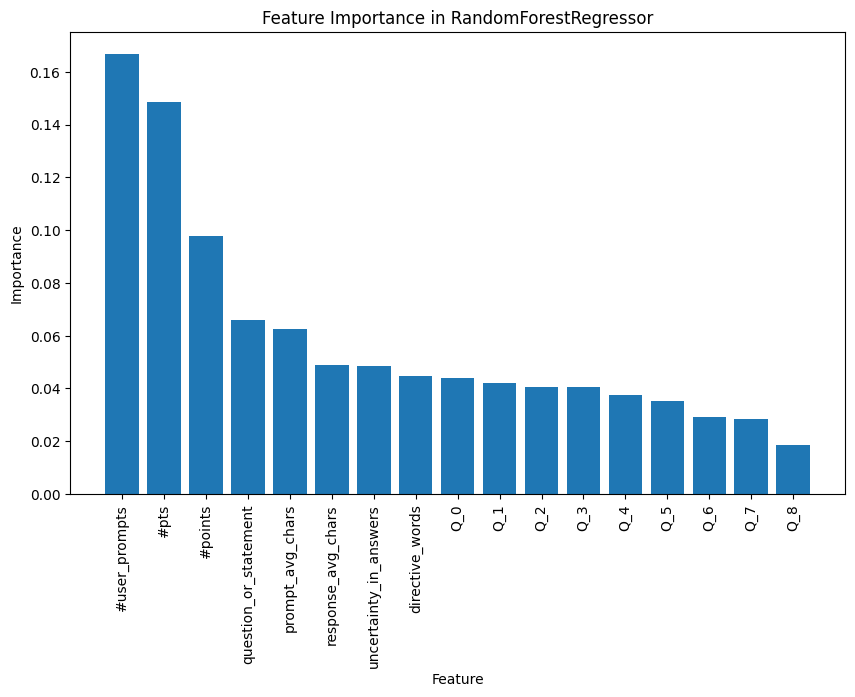

----------
Mean value of MSE Train: 10.185516206666666
Mean value of MSE TEST: 78.30633213333336
Mean value of R2 Train: 0.8440066047681272
Mean value of R2 TEST: -0.4379636280040159


In [453]:
# Number of folds. 5 to 10 is commonly used.
k = 5

# Shuffle data.
np.random.shuffle(X)
np.random.shuffle(y)

# Split the array into k arrays
split_X = np.array_split(X, k)
split_y = np.array_split(y, k)

mse_train = []
mse_test = []
r2_train = []
r2_test = []

# Display the resulting arrays
for i in range(k):
    X_test = split_X[i]
    X_train = np.concatenate([split_X[j] for j in range(k) if j != i])
    y_test = split_y[i]
    y_train = np.concatenate([split_y[j] for j in range(k) if j != i])

    print("Turn: ", i)
    print("Train set size:", len(X_train))
    print("Test set size:", len(X_test))

    regressor = RandomForestRegressor(n_estimators=1000, random_state=0)  # You can adjust the number of estimators
    regressor.fit(X_train, y_train)

    feature_importances = regressor.feature_importances_
    indices = feature_importances.argsort()[::-1]
    feature_names = temp_df.columns[1:-1]

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
    plt.xticks(range(X.shape[1]), feature_names, rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.title("Feature Importance in RandomForestRegressor")
    plt.show()

    # Prediction
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)

    mse_train.append(mean_squared_error(y_train,y_train_pred))
    mse_test.append(mean_squared_error(y_test,y_test_pred))
    r2_train.append(r2_score(y_train,y_train_pred))
    r2_test.append(r2_score(y_test,y_test_pred))

    print("----------")

# Calculate & print Mean Squared Error (MSE)
print("Mean value of MSE Train:", np.mean(mse_train))
print("Mean value of MSE TEST:", np.mean(mse_test))

print("Mean value of R2 Train:", np.mean(r2_train))
print("Mean value of R2 TEST:", np.mean(r2_test))


#### Fitting a model

#### Predicting and Analyzing 

In [454]:
# Use RandomForestRegressor instead of DecisionTreeRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

[0.02760293 0.02929044 0.02109934 0.15331228 0.03199355 0.04934302
 0.09106746 0.039136   0.04293087 0.0322075  0.05962135 0.03912392
 0.03793613 0.05109491 0.04991133 0.04325524 0.20107372]


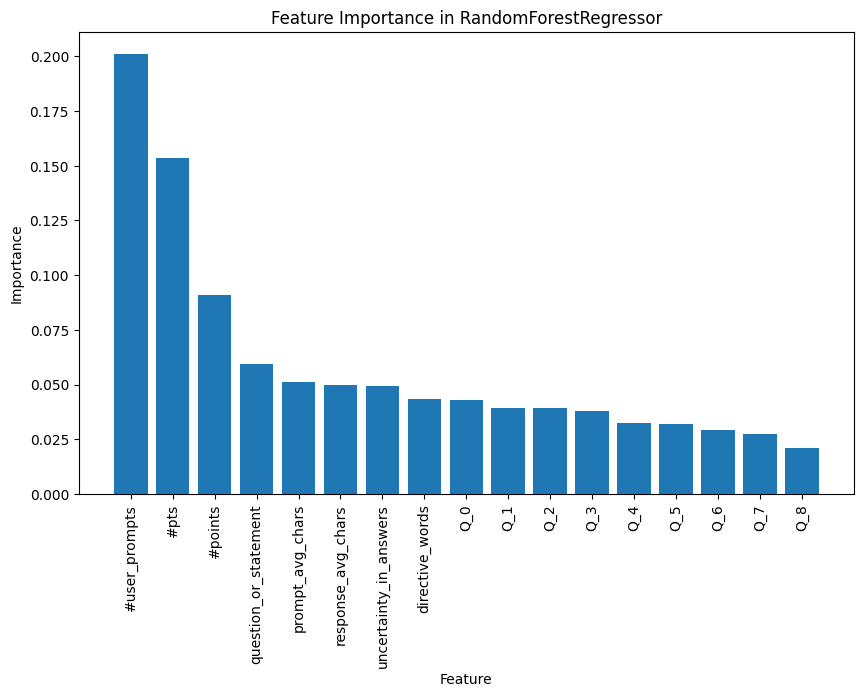

In [455]:
# Get feature importances
feature_importances = regressor.feature_importances_

print(feature_importances)

# Sort feature importances in descending order
indices = feature_importances.argsort()[::-1]

# Access the original column names
feature_names = temp_df.columns[1:-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importance in RandomForestRegressor")
plt.show()

In [456]:
mse_train = []
mse_test = []
r2_train = []
r2_test = []

for i in np.arange(0,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    # print("Train set size:", len(X_train))
    # print("Test set size:", len(X_test))

    # Prediction
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)

    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_test.append(mean_squared_error(y_test, y_test_pred))
    r2_train.append(r2_score(y_train, y_train_pred))
    r2_test.append(r2_score(y_test, y_test_pred))

# Calculate & print Mean Squared Error (MSE)
print("Mean value of MSE Train:", np.mean(mse_train))
print("Mean value of MSE TEST:", np.mean(mse_test))

print("Mean value of R2 Train:", np.mean(r2_train))
print("Mean value of R2 TEST:", np.mean(r2_test))

Mean value of MSE Train: 16.088397199999996
Mean value of MSE TEST: 15.795384533333332
Mean value of R2 Train: 0.7470926415079063
Mean value of R2 TEST: 0.6059878139438487
